In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn.objects as so

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### データ準備

In [2]:
URL = "https://github.com/makaishi2/samples/raw/main/data/irt-sample.csv"
df = pd.read_csv(URL, index_col=0)

display(df.head())
print(df.shape)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,...,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,...,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,...,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,...,1,1,1,0,1,0,0,1,0,0


(1000, 50)


In [3]:
response_df = (
    df
    .reset_index()
    .melt(id_vars=["index"], var_name="question", value_name="response")
    .rename(columns={"index": "user"})
)
print(f"元データ(df): {df.shape}")
print(f"変換後データ(response_df): {response_df.shape}")

display(response_df.head())

元データ(df): (1000, 50)
変換後データ(response_df): (50000, 3)


,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


In [4]:
user_idx, users = response_df["user"].factorize()
question_idx, questions = response_df["question"].factorize()
response = response_df["response"].to_numpy()

print("--- USER ---")
print(user_idx, user_idx.size)
print(users)

print("--- QUESTION ---")
print(question_idx, question_idx.size)
print(questions)

print("---RESPONSE ---")
print(response, response.size)

--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)
--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')
---RESPONSE ---
[0 1 1 ... 1 1 1] 50000


### 確率モデル定義

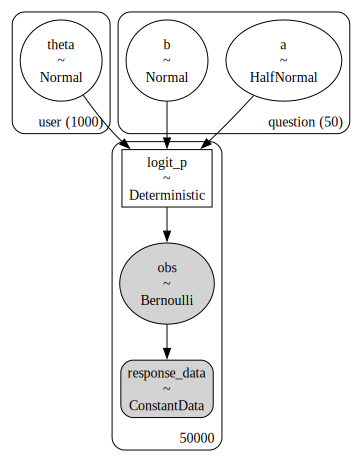

In [5]:
with pm.Model(coords={"user": users, "question": questions}) as model1:
    response_data = pm.ConstantData("response_data", response)
    # 能力値（受験者ごと）
    theta = pm.Normal("theta", mu=0.0, sigma=1.0, dims="user")
    # 識別力（設問ごと）
    a = pm.HalfNormal("a", sigma=1.0, dims="question")
    # 困難度（設問ごと）
    b = pm.Normal("b", mu=0.0, sigma=1.0, dims="question")

    # 2 パラメータロジスティックモデル
    logit_p = pm.Deterministic(
        "logit_p",
        a[question_idx] * (theta[user_idx] - b[question_idx])
    )
    # ベルヌーイ分布（1: 正答, 0: 誤答）
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

g = pm.model_to_graphviz(model1)
display(g)

### サンプリングと結果分析

In [6]:
%%time
with model1:
    idata1 = pm.sample(random_seed=42, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 128 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


CPU times: user 3.14 s, sys: 496 ms, total: 3.63 s
Wall time: 2min 8s


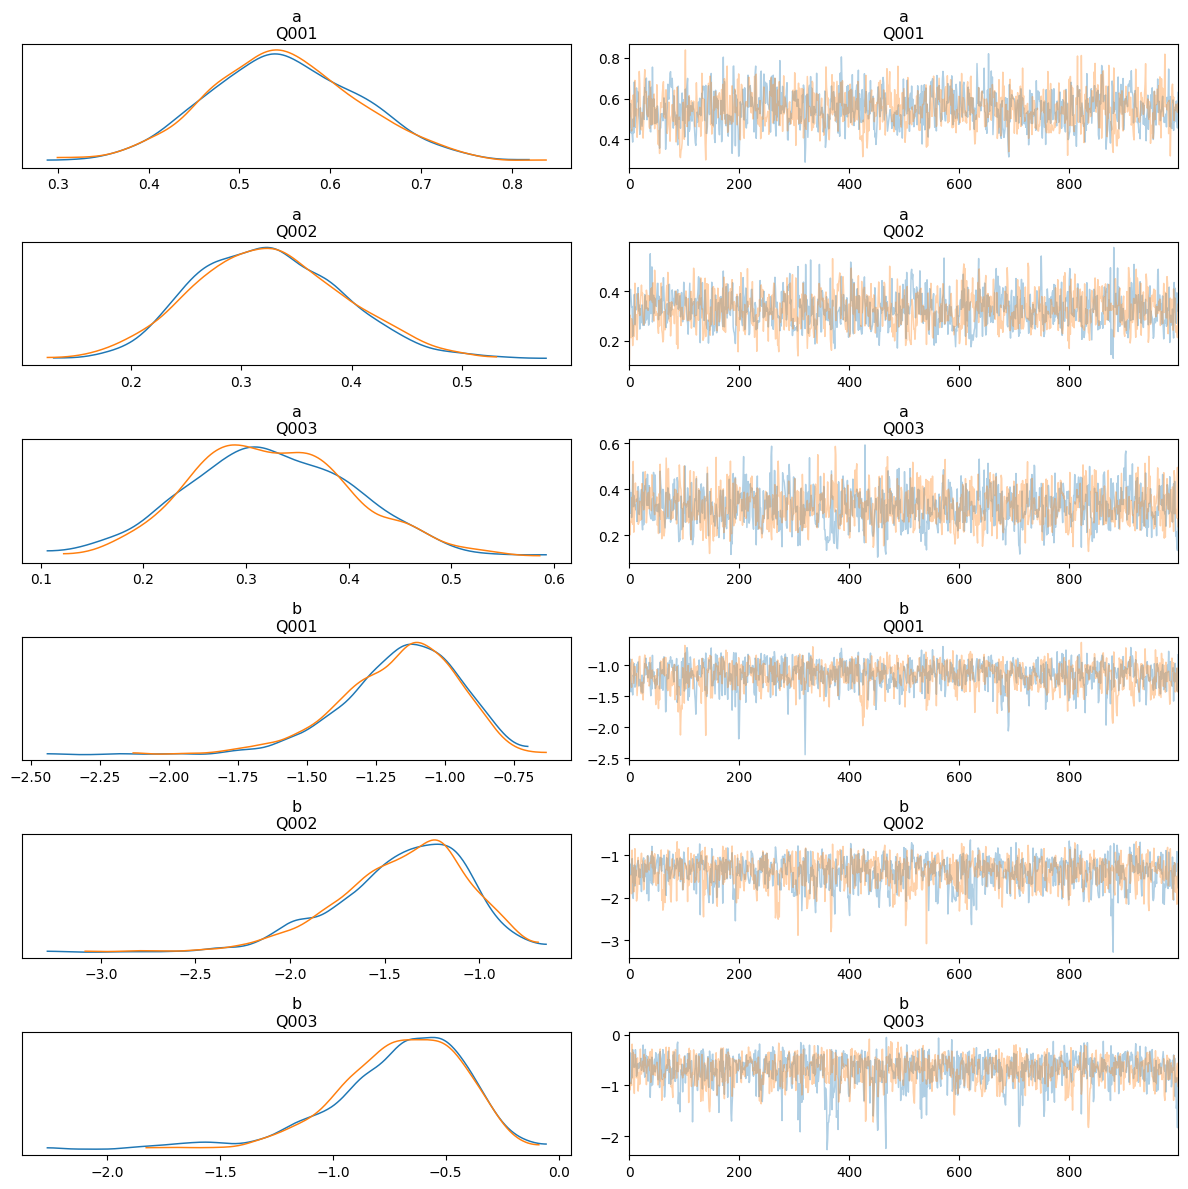

In [7]:
az.plot_trace(
    idata1,
    var_names=["a", "b"],
    coords={"question": ["Q001", "Q002", "Q003"]},
    compact=False
)
plt.tight_layout()

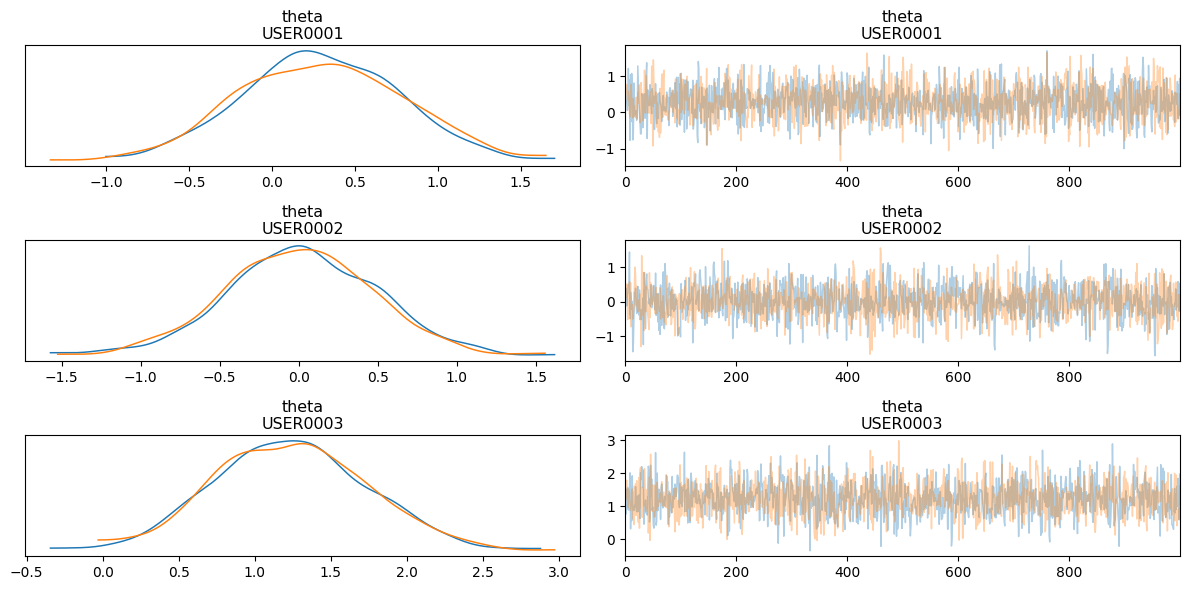

In [8]:
az.plot_trace(
    idata1,
    var_names=["theta"],
    coords={"user": ["USER0001", "USER0002", "USER0003"]},
    compact=False
)
plt.tight_layout()

### 詳細分析

In [9]:
summary_a1 = az.summary(idata1, var_names=["a"])
summary_b1 = az.summary(idata1, var_names=["b"])

display(summary_a1.head())
display(summary_b1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[Q001],0.549,0.085,0.392,0.710,0.003,0.002,996.0,1128.0,1.0
a[Q002],0.325,0.068,0.210,0.459,0.002,0.002,981.0,1040.0,1.0
a[Q003],0.325,0.079,0.180,0.474,0.003,0.002,892.0,761.0,1.0
a[Q004],0.696,0.095,0.513,0.872,0.003,0.002,950.0,943.0,1.0
a[Q005],0.757,0.104,0.558,0.947,0.004,0.003,702.0,573.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Q001],-1.164,0.213,-1.555,-0.800,0.007,0.005,1140.0,1009.0,1.0
b[Q002],-1.409,0.345,-2.040,-0.815,0.011,0.008,1108.0,1066.0,1.0
b[Q003],-0.709,0.294,-1.239,-0.227,0.010,0.008,1091.0,731.0,1.0
b[Q004],-1.785,0.247,-2.262,-1.367,0.008,0.006,1042.0,934.0,1.0
b[Q005],-2.331,0.295,-2.867,-1.786,0.012,0.008,723.0,585.0,1.0


In [10]:
summary_theta1 = az.summary(idata1, var_names=["theta"])
display(summary_theta1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0001],0.293,0.476,-0.625,1.134,0.010,0.010,2408.0,1547.0,1.0
theta[USER0002],0.009,0.471,-0.913,0.869,0.011,0.010,2000.0,1364.0,1.0
theta[USER0003],1.235,0.501,0.301,2.167,0.012,0.008,1851.0,1556.0,1.0
theta[USER0004],-0.769,0.463,-1.624,0.106,0.010,0.008,1950.0,1361.0,1.0
theta[USER0005],-0.538,0.475,-1.421,0.329,0.011,0.009,1806.0,1303.0,1.0


### 偏差値と能力値の関係

In [11]:
df_sum1 = (
    pd.DataFrame(df.mean(axis=1) * 100)
    .rename(columns={0: "素点"})
)
df_sum1["mean"] = df_sum1["素点"].mean()
df_sum1["std"] = df_sum1["素点"].std(ddof=0)
df_sum1["偏差値"] = (df_sum1["素点"] - df_sum1["mean"]) / df_sum1["std"] * 10 + 50
df_sum1 = df_sum1.drop(["mean", "std"], axis=1)

# 能力値
x1 = summary_theta1["mean"].to_numpy()
x1_mean, x1_std = x1.mean(), x1.std(ddof=1) # 不偏標準偏差
df_sum1["能力値"] = (x1 - x1_mean) / x1_std * 10 + 50

display(df_sum1)

,素点,偏差値,能力値
USER0001,64.0,53.308375,53.004206
USER0002,58.0,48.447883,49.582875
USER0003,78.0,64.649522,64.352422
USER0004,48.0,40.347063,40.210356
USER0005,50.0,41.967227,42.993199
...,...,...,...
USER0996,66.0,54.928539,55.196749
USER0997,60.0,50.068047,51.992263
USER0998,70.0,58.168867,56.859226
USER0999,62.0,51.688211,52.739173


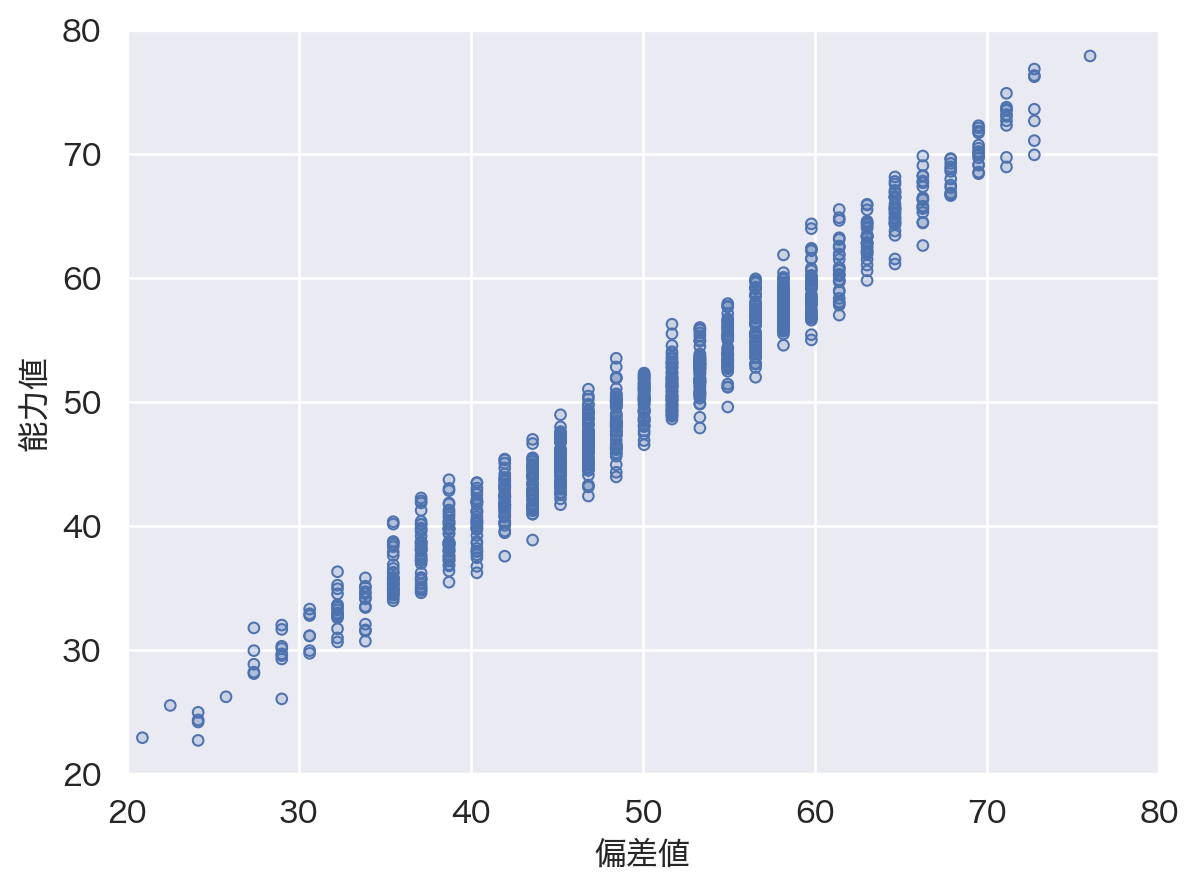

In [12]:
(
    so.Plot(df_sum1, x="偏差値", y="能力値")
    .add(so.Dots())
    .limit(x=(20, 80), y=(20, 80))
    .theme({"font.family": "Hiragino Sans"})
)

### 同じ偏差値の受験者間の能力値の違いの分析

In [13]:
df_62_1 = df_sum1[df_sum1["素点"] == 62]
print(f"素点62点の受験者数: {len(df_62_1)}")

print()

print(f"素点62点で一番能力値の低い受験者:\n{df_62_1.loc[df_62_1['能力値'].idxmin()]}")

print()

print(f"素点62点で一番能力値の低い受験者:\n{df_62_1.loc[df_62_1['能力値'].idxmax()]}")

素点62点の受験者数: 59

素点62点で一番能力値の低い受験者:
素点     62.000000
偏差値    51.688211
能力値    48.607073
Name: USER0463, dtype: float64

素点62点で一番能力値の低い受験者:
素点     62.000000
偏差値    51.688211
能力値    56.256879
Name: USER0064, dtype: float64


In [14]:
df

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,...,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,...,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,...,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,...,1,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER0996,1,1,0,1,1,1,1,0,0,1,...,0,1,1,1,0,0,1,0,0,1
USER0997,0,0,0,1,1,1,1,1,0,1,...,1,1,1,0,1,0,1,1,1,1
USER0998,1,1,0,1,1,1,1,1,1,0,...,1,1,1,1,1,0,0,1,1,1
USER0999,1,0,0,1,1,1,1,0,0,1,...,0,1,1,1,0,0,0,1,0,1


In [15]:
w1 = df.loc[
    [df_62_1['能力値'].idxmin(), df_62_1['能力値'].idxmax()]
]
display(w1)

w2 = w1.sum(axis=1)
print(f"w1 の shape: {w1.shape}\n正解数:\n{w2}")

print()

# 問題別の平均困難度
b_mean1 = az.summary(idata1, var_names=["b"])["mean"].to_numpy().reshape(1, -1)
print(b_mean1)
print(f"b_mean の shape: {b_mean1.shape}")

print()

# 2人の受験者が解いた問題の平均困難度
w3 = (w1 * b_mean1).sum(axis=1) / w2.mean()
print(w3)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0463,0,0,1,1,1,1,1,1,0,0,...,0,1,1,1,1,1,0,0,1,1
USER0064,1,0,1,1,1,0,1,0,0,0,...,0,1,1,0,1,1,0,1,1,1


w1 の shape: (2, 50)
正解数:
USER0463    31
USER0064    31
dtype: int64

[[-1.164 -1.409 -0.709 -1.785 -2.331 -1.406 -2.112 -1.859  1.244  1.287
  -0.569 -1.95  -0.672  0.294 -0.086  0.332  0.074 -2.372 -1.756 -1.025
  -1.574 -1.84   1.348 -1.495  1.289  1.07  -1.685 -0.289 -1.944 -2.189
  -0.177  0.011 -0.895 -0.644 -1.267  0.267 -1.564 -1.401 -2.078  0.601
  -0.066 -1.284 -2.846 -1.356  0.62   0.453  0.52  -1.759 -2.012 -1.847]]
b_mean の shape: (1, 50)

USER0463   -1.202258
USER0064   -1.110355
dtype: float64


<Axes: >

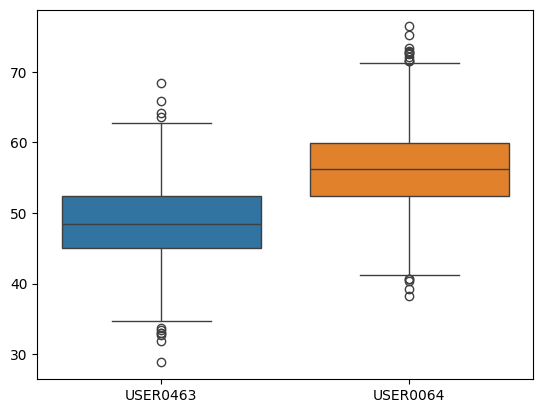

In [16]:
w1 = idata1["posterior"]["theta"].loc[:, :, ["USER0463", "USER0064"]].to_numpy()
w2 = w1.T.reshape(2, -1)
w3 = (w2 - x1_mean) / x1_std * 10 + 50

df_w3 = pd.DataFrame(w3.T, columns=["USER0463", "USER0064"])

import seaborn as sns
sns.boxplot(df_w3)

### 変分推論法の利用

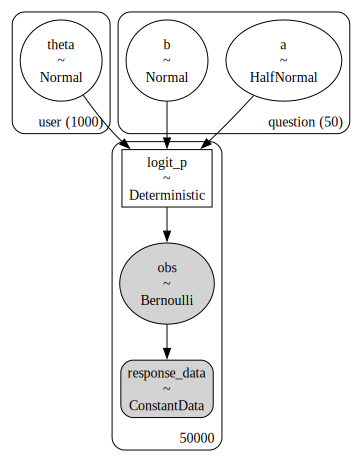

In [17]:
with pm.Model(coords={"user": users, "question": questions}) as model2:
    response_data = pm.ConstantData("response_data", response)
    # 能力値（受験者ごと）
    theta = pm.Normal("theta", mu=0.0, sigma=1.0, dims="user")
    # 識別力（設問ごと）
    a = pm.HalfNormal("a", sigma=1.0, dims="question")
    # 困難度（設問ごと）
    b = pm.Normal("b", mu=0.0, sigma=1.0, dims="question")

    # 2 パラメータロジスティックモデル
    logit_p = pm.Deterministic(
        "logit_p",
        a[question_idx] * (theta[user_idx] - b[question_idx])
    )
    # ベルヌーイ分布（1: 正答, 0: 誤答）
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

g = pm.model_to_graphviz(model2)
display(g)

#### fit 関数呼び出し

In [18]:
%%time

with model2:
    mean_field = pm.fit(method=pm.ADVI(), n=20_000, obj_optimizer=pm.adam())

Finished [100%]: Average Loss = 30,872


CPU times: user 49 s, sys: 1.55 s, total: 50.5 s
Wall time: 50.5 s


#### 収束確認

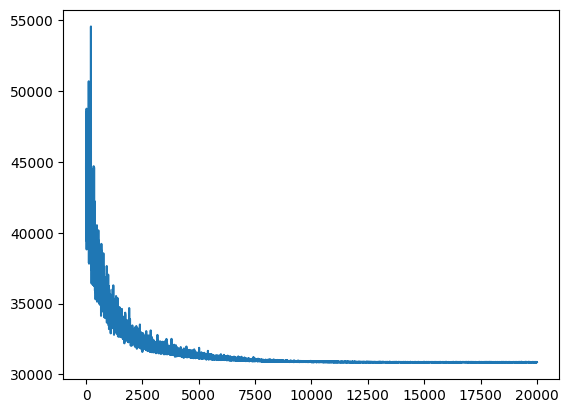

In [19]:
plt.plot(mean_field.hist);

#### サンプリング

In [20]:
%%time

idata2 = mean_field.sample(2_000)

CPU times: user 1.1 s, sys: 1.83 s, total: 2.93 s
Wall time: 1.1 s


In [21]:
summary_theta2 = az.summary(idata2, var_names=["theta"])
df_sum2 = df_sum1.copy()

x2 = summary_theta2["mean"].to_numpy()
x2_mean, x2_std = x2.mean(), x2.std(ddof=1) # 不偏標準偏差
df_sum2["能力値2"] = (x2 - x2_mean) / x2_std * 10 + 50

display(df_sum2.head(10))

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,素点,偏差値,能力値,能力値2
USER0001,64.0,53.308375,53.004206,52.972884
USER0002,58.0,48.447883,49.582875,49.939560
USER0003,78.0,64.649522,64.352422,64.688201
USER0004,48.0,40.347063,40.210356,40.349959
USER0005,50.0,41.967227,42.993199,42.487616
USER0006,62.0,51.688211,49.100997,48.793107
USER0007,52.0,43.587391,41.499378,41.711372
USER0008,54.0,45.207555,44.740005,45.138788
USER0009,60.0,50.068047,49.281701,49.270796
USER0010,62.0,51.688211,49.209420,48.625916


<Axes: >

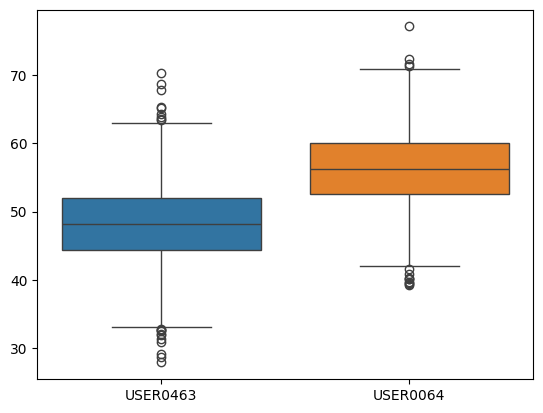

In [22]:
w1 = idata2["posterior"]["theta"].loc[:, :, ["USER0463", "USER0064"]].to_numpy()
w2 = w1.T.reshape(2, -1)
w3 = (w2 - x2_mean) / x2_std * 10 + 50
df_w3 = pd.DataFrame(w3.T, columns=["USER0463", "USER0064"])

sns.boxplot(df_w3)